In [1]:
%pip install -q srai[voronoi,osm,plotting] geodatasets
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import geodatasets
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

from shapely.geometry import MultiPoint, Point
from shapely.ops import voronoi_diagram

from srai.regionalizers import VoronoiRegionalizer, geocode_to_region_gdf

In [3]:
earth_points_gdf = gpd.GeoDataFrame(
    geometry=[
        Point(0, 0),
        Point(90, 0),
        Point(180, 0),
        Point(-90, 0),
        Point(0, 90),
        Point(0, -90),
    ],
    index=[1, 2, 3, 4, 5, 6],
    crs="EPSG:4326",
)

world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

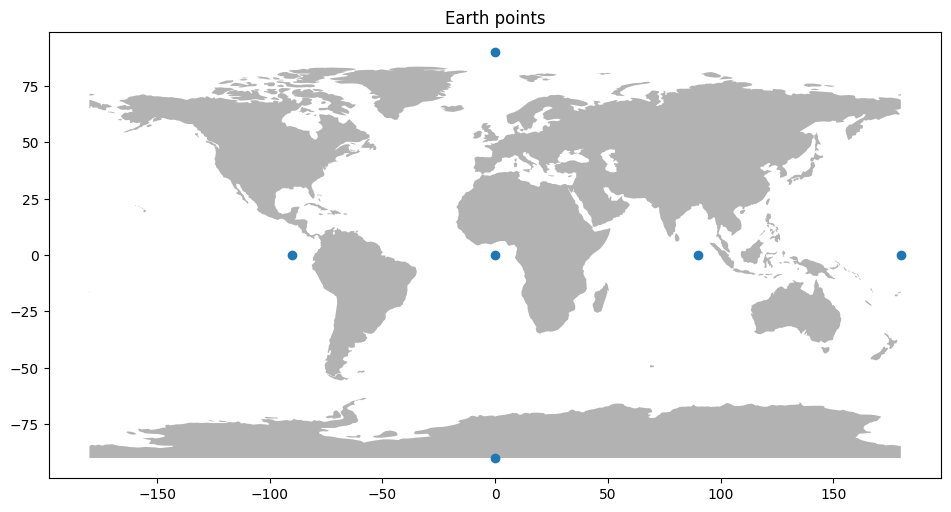

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
world.plot(ax=ax, alpha=0.6, color="grey")
earth_points_gdf.plot(ax=ax)
fig.tight_layout()
plt.title("Earth points")
plt.show()

In [5]:
def generate_flat_voronoi_diagram_regions(
    seeds_gdf: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:
    points = MultiPoint(seeds_gdf.geometry.values)
    regions = voronoi_diagram(points)

    flat_voronoi_regions = gpd.GeoDataFrame(
        geometry=list(regions.geoms),
        crs="EPSG:4326",
    )
    flat_voronoi_regions.index = gpd.pd.Index(
        flat_voronoi_regions.sjoin(seeds_gdf)["index_right"],
        name="region_id",
    )
    flat_voronoi_regions.geometry = flat_voronoi_regions.geometry.clip_by_rect(
        xmin=-180, ymin=-90, xmax=180, ymax=90
    )
    return flat_voronoi_regions

In [6]:
earth_points_flat_voronoi_regions = generate_flat_voronoi_diagram_regions(
    earth_points_gdf
)
earth_points_flat_voronoi_regions

geometry
region_id                                                   
4          POLYGON ((-180.00000 -90.00000, -180.00000 90....
6          POLYGON ((-90.00000 -90.00000, -45.00000 -45.0...
2          POLYGON ((45.00000 -45.00000, 45.00000 45.0000...
3          POLYGON ((135.00000 -90.00000, 135.00000 90.00...
5          POLYGON ((-90.00000 90.00000, 90.00000 90.0000...
1          POLYGON ((-45.00000 -45.00000, -45.00000 45.00...

In [7]:
earth_points_spherical_voronoi_regions = VoronoiRegionalizer(
    seeds=earth_points_gdf
).transform()
earth_points_spherical_voronoi_regions

/mnt/c/Development/Python/medium-articles/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating spherical polygons:   0%|          | 0/6 [00:00<?, ?it/s]/mnt/c/Development/Python/medium-articles/.venv/lib/python3.11/site-packages/spherical_geometry/great_circle_arc.py:363: RuntimeWarning: invalid value encountered in divide
  return P / l
Generating polygons: 100%|██████████| 6/6 [00:00<00:00, 70.71it/s]


geometry
region_id                                                   
6          POLYGON ((45.19105 -35.35420, 45.28673 -35.398...
4          POLYGON ((-45.00000 -0.08996, -45.00000 -0.179...
1          POLYGON ((0.12722 44.99993, 0.25444 44.99972, ...
3          MULTIPOLYGON (((135.19105 35.35420, 135.28673 ...
2          POLYGON ((45.00000 0.08996, 45.00000 0.17992, ...
5          POLYGON ((134.80895 35.35420, 134.71327 35.398...

In [8]:
def plot_flat(
    seeds_gdf: gpd.GeoDataFrame,
    regions_gdf: gpd.GeoDataFrame,
    marker_size: float = None,
    title: str = None,
) -> None:
    fig, ax = plt.subplots(figsize=(20, 10))
    world.plot(ax=ax, alpha=0.6, color="grey")
    regions_gdf.reset_index().plot(
        ax=ax, alpha=0.4, column="region_id", edgecolor="black", linewidth=0.5
    )
    seeds_gdf.plot(ax=ax, alpha=0.6, color="black", markersize=marker_size)
    ax.set_axis_off()
    fig.tight_layout()
    if title:
        plt.title(title)
    plt.show()


def plot_on_globe(
    seeds_gdf: gpd.GeoDataFrame,
    regions_gdf: gpd.GeoDataFrame,
    lon: float,
    lat: float,
    zoom: float = 1,
    marker_size: float = 5,
    title: str = None,
) -> None:
    fig = px.choropleth(
        regions_gdf,
        geojson=regions_gdf.geometry,
        locations=regions_gdf.index,
        color=regions_gdf.index,
        color_continuous_scale=px.colors.qualitative.Bold,
    )
    fig2 = px.scatter_geo(seeds_gdf, lat=seeds_gdf.geometry.y, lon=seeds_gdf.geometry.x)
    fig.update_traces(marker={"opacity": 0.4}, selector=dict(type="choropleth"))
    fig.add_trace(fig2.data[0])
    fig.update_traces(
        marker_color="black", marker_size=marker_size, selector=dict(type="scattergeo")
    )
    fig.update_layout(coloraxis_showscale=False)
    fig.update_geos(
        projection_type="orthographic",
        projection_rotation_lon=lon,
        projection_rotation_lat=lat,
        showlakes=False,
        projection_scale=zoom,
    )
    fig.update_layout(
        height=800, width=800, margin={"r": 15, "t": 15, "l": 15, "b": 15}
    )
    if title:
        fig.update_layout(title=dict(text=title, automargin=True, x=0.5))
    fig.show(renderer="png")  # replace with fig.show() to allow interactivity

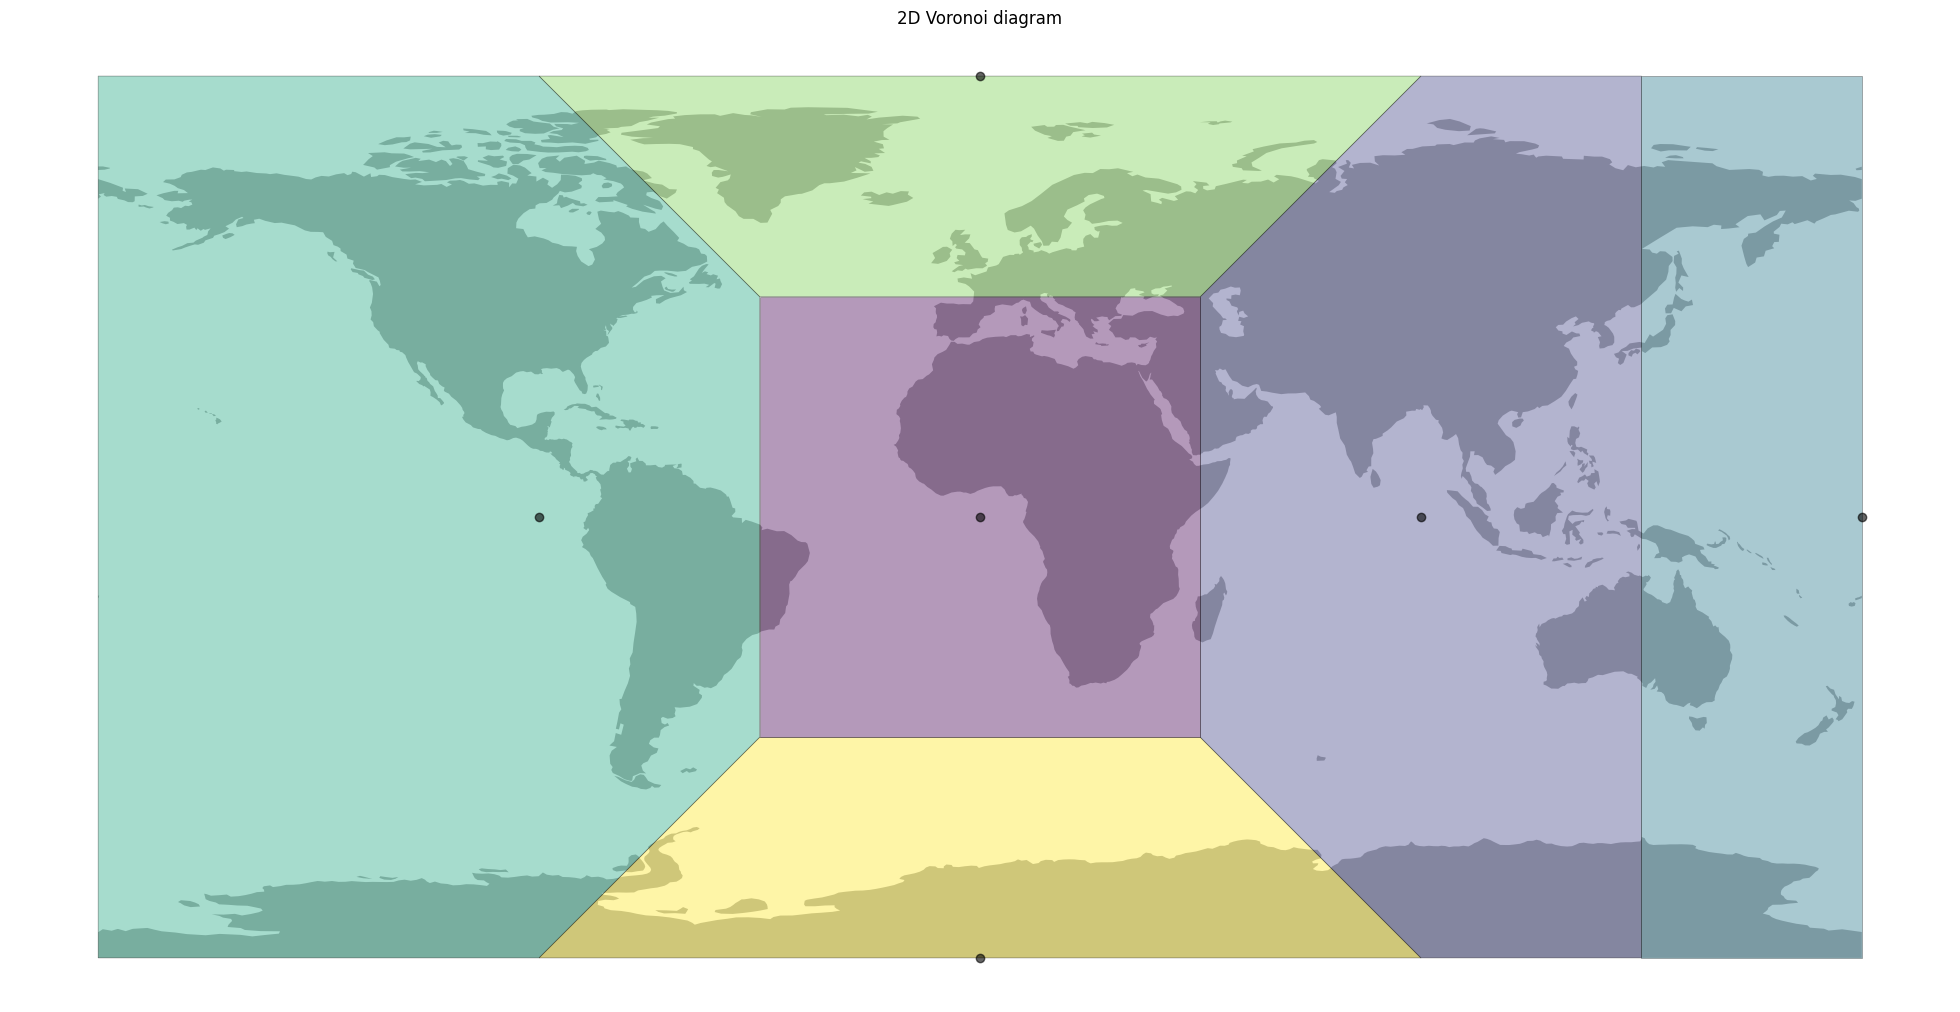

In [9]:
plot_flat(
    earth_points_gdf, earth_points_flat_voronoi_regions, title="2D Voronoi diagram"
)

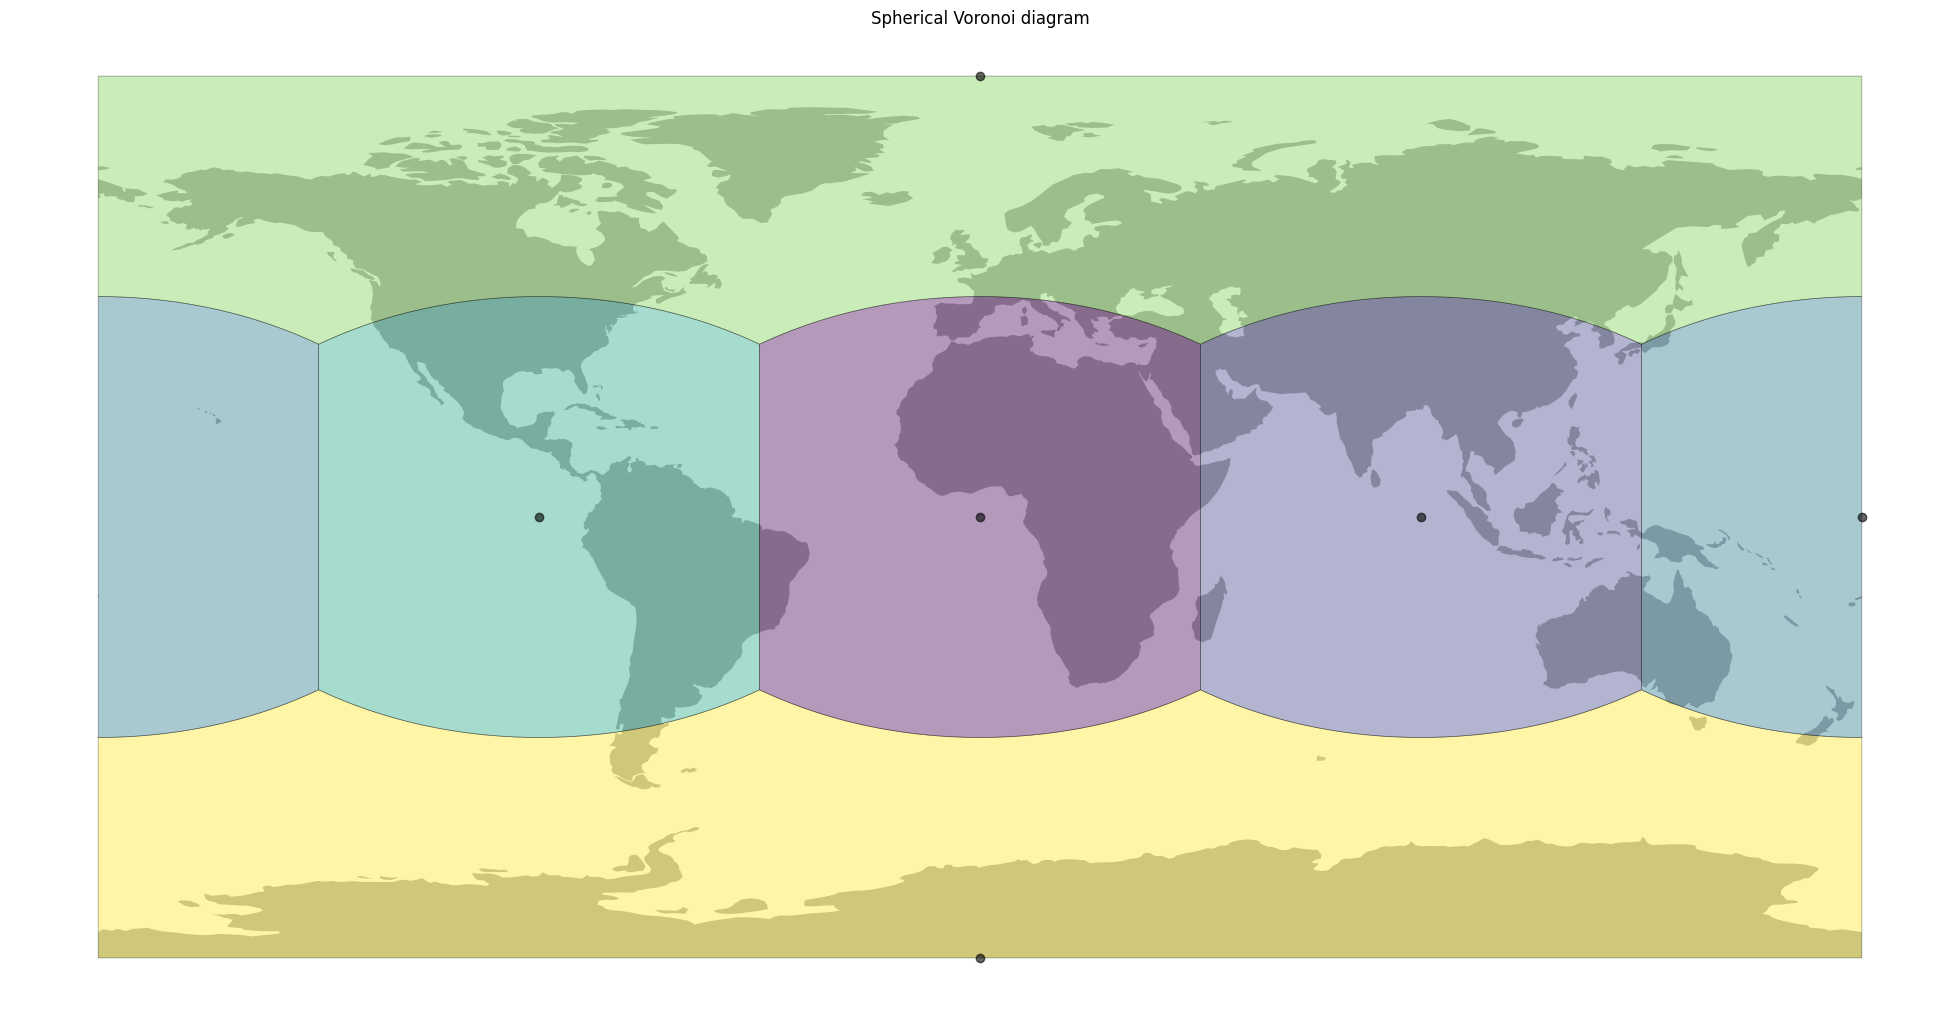

In [10]:
plot_flat(
    earth_points_gdf,
    earth_points_spherical_voronoi_regions,
    title="Spherical Voronoi diagram",
)

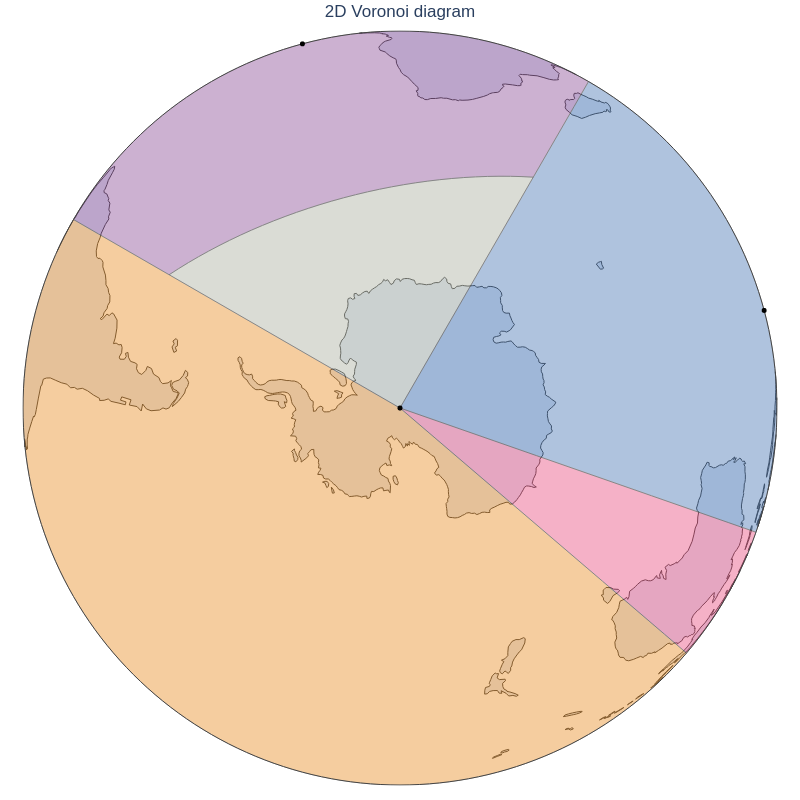

In [11]:
plot_on_globe(
    earth_points_gdf,
    earth_points_flat_voronoi_regions,
    lon=15,
    lat=-90,
    title="2D Voronoi diagram",
)

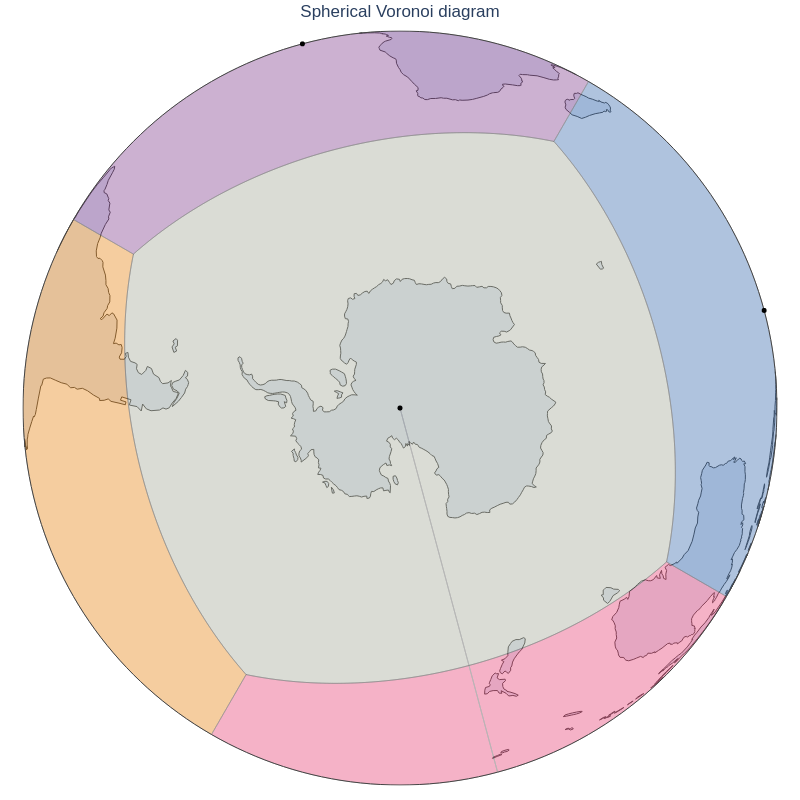

In [12]:
plot_on_globe(
    earth_points_gdf,
    earth_points_spherical_voronoi_regions,
    lon=15,
    lat=-90,
    title="Spherical Voronoi diagram",
)

In [9]:
def calculate_iou(
    flat_regions: gpd.GeoDataFrame, spherical_regions: gpd.GeoDataFrame
) -> float:
    total_intersections_area = 0
    total_unions_area = 0

    for index in spherical_regions.index:
        spherical_region_geometry = spherical_regions.loc[index].geometry
        flat_region_geometry = flat_regions.loc[index].geometry

        intersections_area = spherical_region_geometry.intersection(
            flat_region_geometry
        ).area
        unions_area = (
            spherical_region_geometry.area
            + flat_region_geometry.area
            - intersections_area
        )

        total_intersections_area += intersections_area
        total_unions_area += unions_area

    return round(total_intersections_area / total_unions_area, 3)

In [10]:
print(
    "Earth points IoU",
    calculate_iou(
        earth_points_flat_voronoi_regions, earth_points_spherical_voronoi_regions
    ),
)

Earth points IoU 0.423


In [11]:
aed_world_gdf = gpd.read_file(
    "https://raw.githubusercontent.com/RaczeQ/medium-articles/main/articles/spherical-geovoronoi/aed_world.geojson"
)
aed_world_gdf

osm_id                   geometry
0       4329167914  POINT (-1.09266 53.95861)
1       9768359257  POINT (-1.08866 53.95908)
2       6925164290  POINT (-1.08772 53.95818)
3      10990348685  POINT (-1.08143 53.95751)
4      11009376813  POINT (-1.08653 53.95771)
...            ...                        ...
80689   9817198517  POINT (18.60840 50.14178)
80690  11001346522  POINT (18.65853 50.23052)
80691  10774155831  POINT (18.60227 50.31532)
80692  10774155836  POINT (18.64456 50.31413)
80693  10774155807  POINT (18.62539 50.34534)

[80694 rows x 2 columns]

In [12]:
aed_flat_voronoi_regions = generate_flat_voronoi_diagram_regions(aed_world_gdf)
aed_flat_voronoi_regions

geometry
region_id                                                   
43443      POLYGON ((-180.00000 35.73412, -180.00000 90.0...
3023       POLYGON ((-146.50598 39.32539, -144.73450 38.2...
23264      POLYGON ((-144.73450 38.29303, -146.50598 39.3...
5504       POLYGON ((-180.00000 -90.00000, -180.00000 0.8...
23201      POLYGON ((-134.86980 -90.00000, -119.07591 -43...
...                                                      ...
71173      POLYGON ((175.09005 -36.81308, 175.09076 -36.8...
30650      POLYGON ((175.12912 -36.77718, 175.12956 -36.7...
60976      POLYGON ((175.09524 -36.80739, 175.09275 -36.8...
40806      POLYGON ((175.13915 -36.80520, 175.13235 -36.8...
71175      POLYGON ((175.13235 -36.81486, 175.13915 -36.8...

[80694 rows x 1 columns]

In [13]:
aed_spherical_voronoi_regions = VoronoiRegionalizer(
    seeds=aed_world_gdf, max_meters_between_points=1_000
).transform()
aed_spherical_voronoi_regions

Generating polygons: 100%|██████████| 80694/80694 [00:15<00:00, 5128.92it/s]


geometry
region_id                                                   
20316      POLYGON ((0.20381 -88.06252, 0.40639 -88.05668...
60645      MULTIPOLYGON (((179.27219 -54.55588, 179.26351...
20330      MULTIPOLYGON (((175.19181 -41.09580, 175.20384...
248        MULTIPOLYGON (((174.05977 -41.71342, 174.06954...
50650      MULTIPOLYGON (((173.72100 -43.23968, 173.71091...
...                                                      ...
40362      POLYGON ((0.63235 54.72750, 0.61981 54.72134, ...
7377       POLYGON ((0.06374 77.48187, 0.09557 77.47582, ...
3056       MULTIPOLYGON (((135.28331 78.68713, 135.29609 ...
23262      MULTIPOLYGON (((179.87127 84.93261, 179.80664 ...
27770      POLYGON ((180.00000 89.98199, 180.00000 89.972...

[80694 rows x 1 columns]

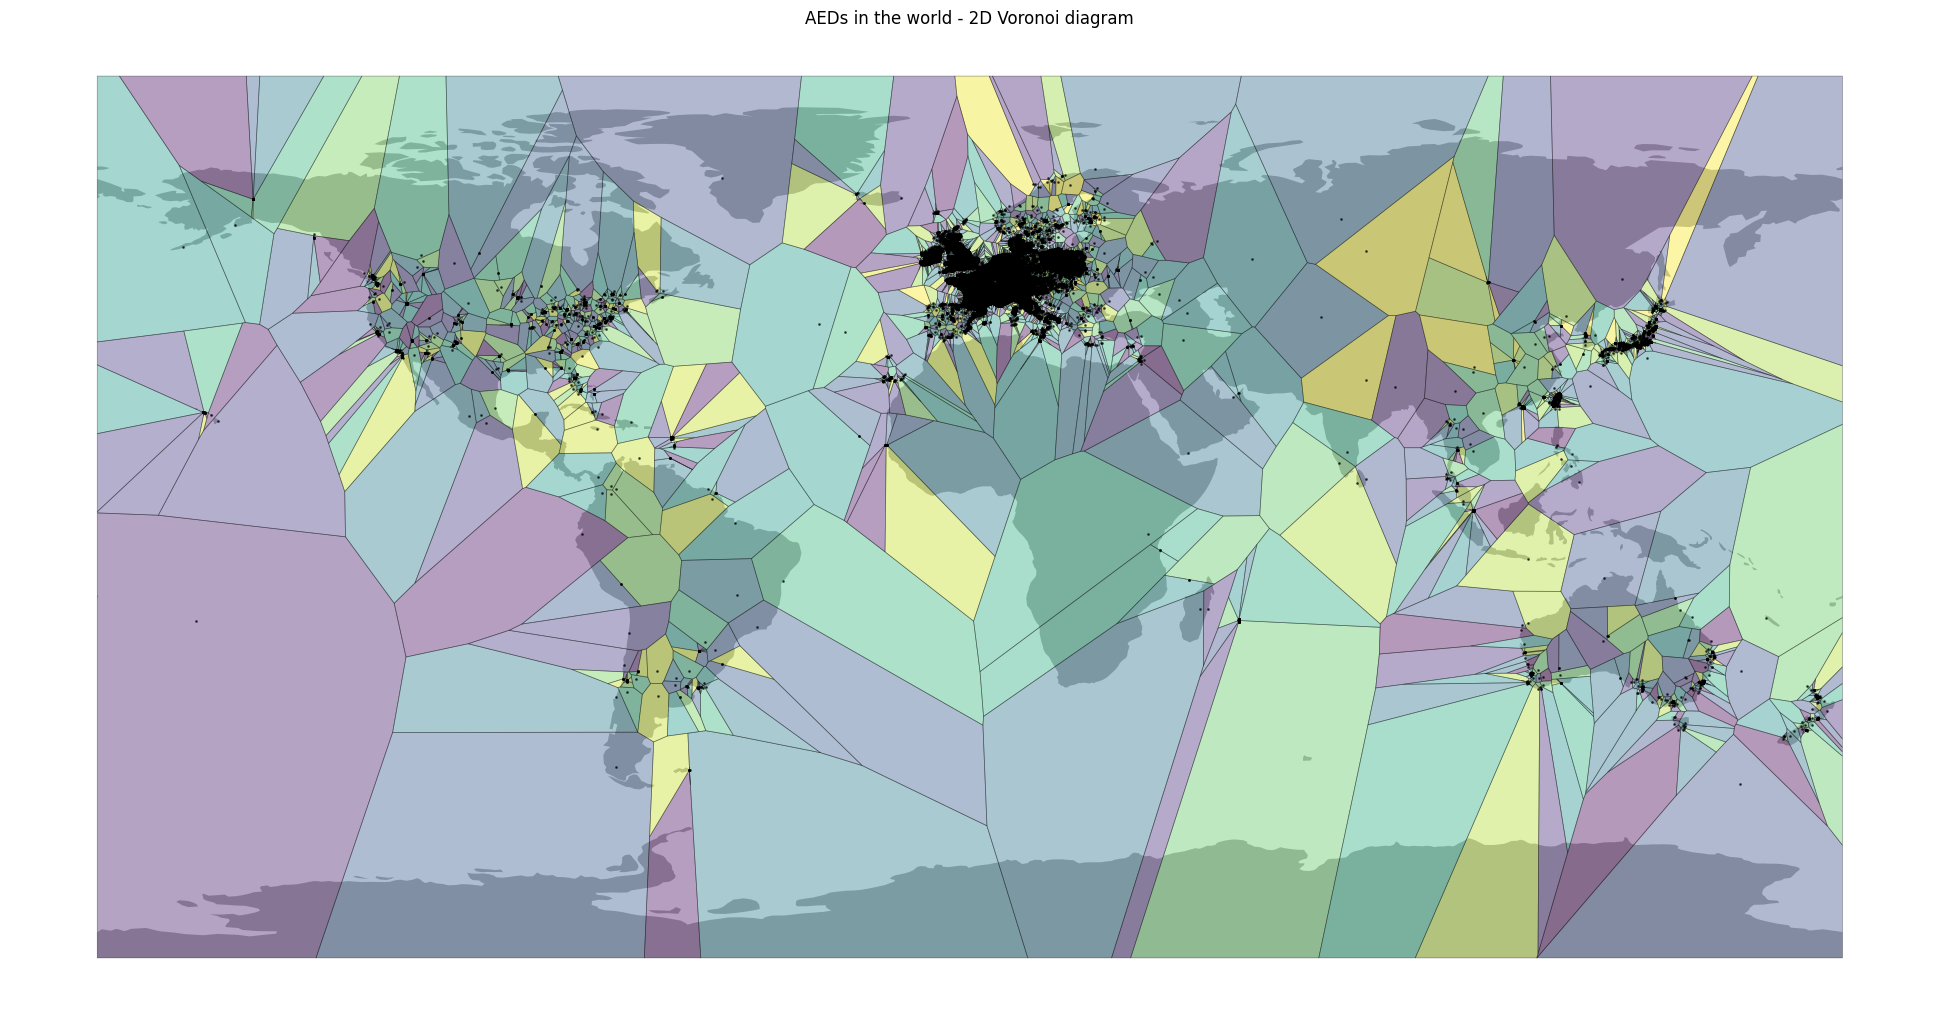

In [18]:
plot_flat(
    aed_world_gdf,
    aed_flat_voronoi_regions,
    marker_size=1,
    title="AEDs in the world - 2D Voronoi diagram",
)

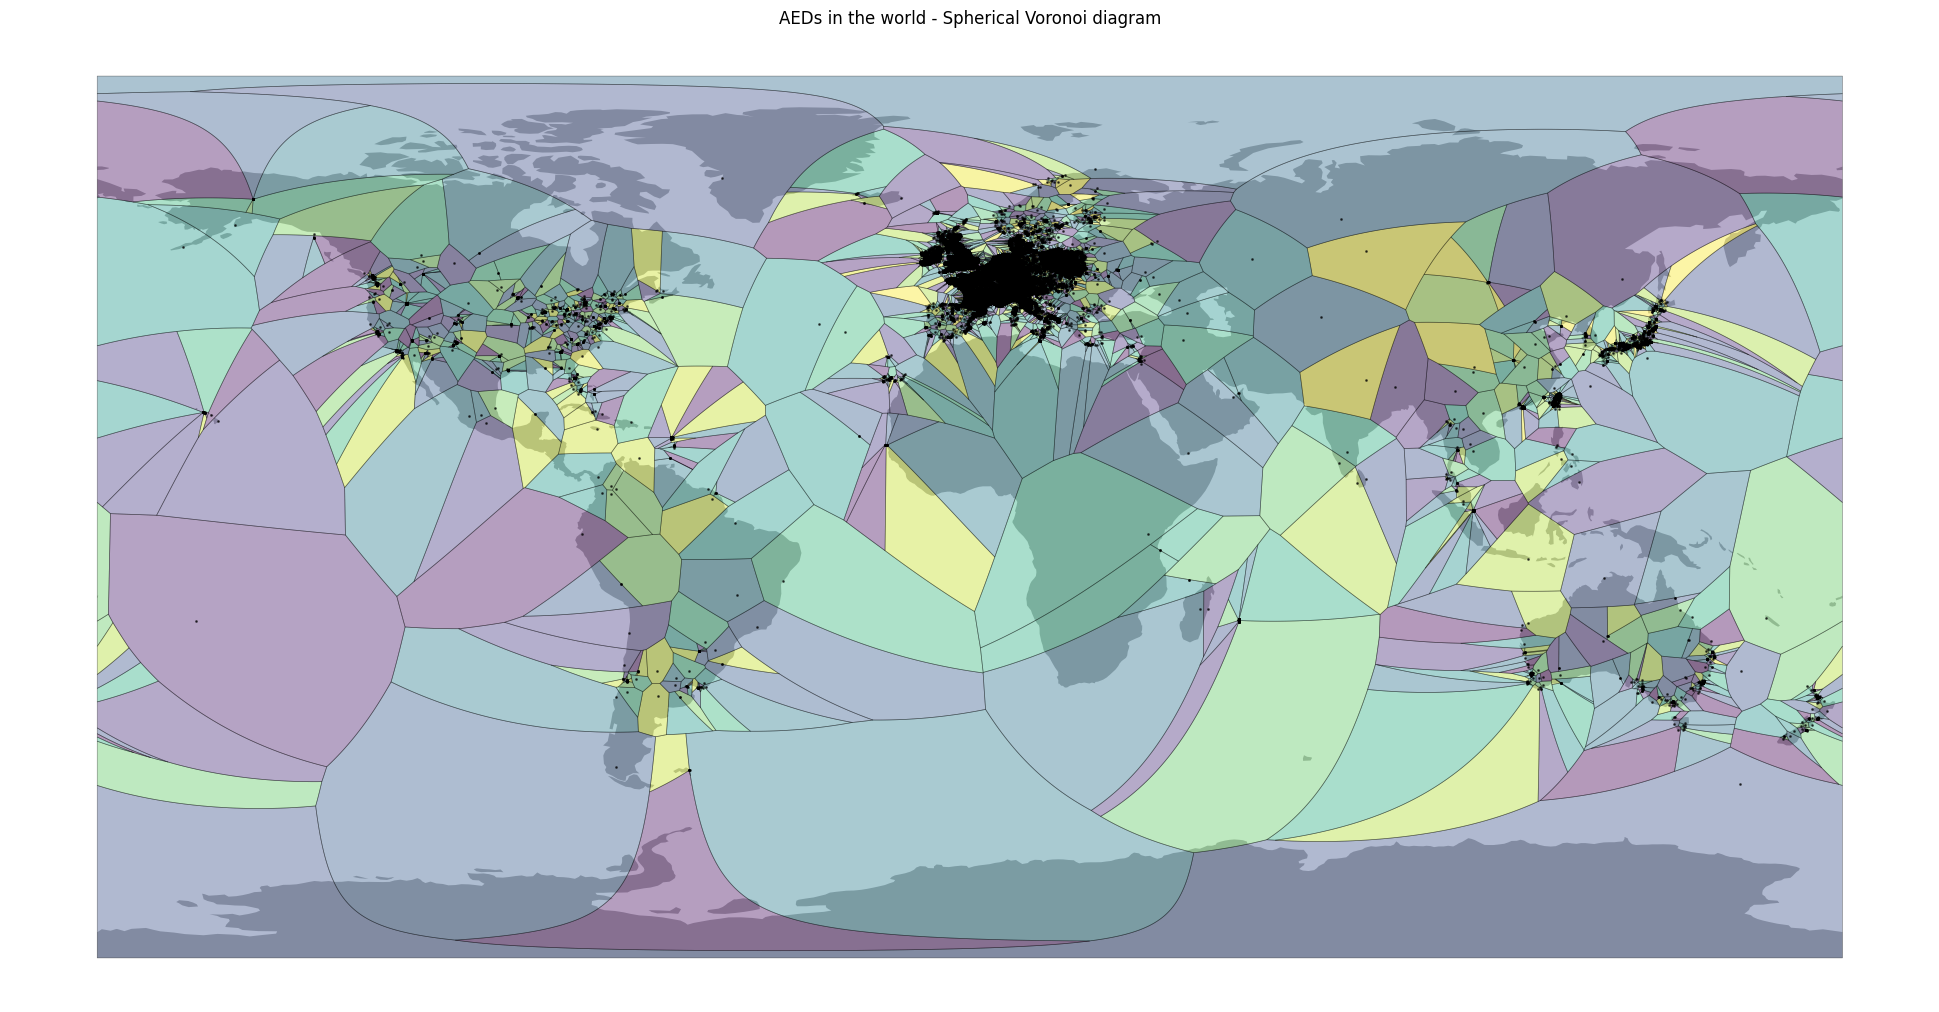

In [19]:
plot_flat(
    aed_world_gdf,
    aed_spherical_voronoi_regions,
    marker_size=1,
    title="AEDs in the world - Spherical Voronoi diagram",
)

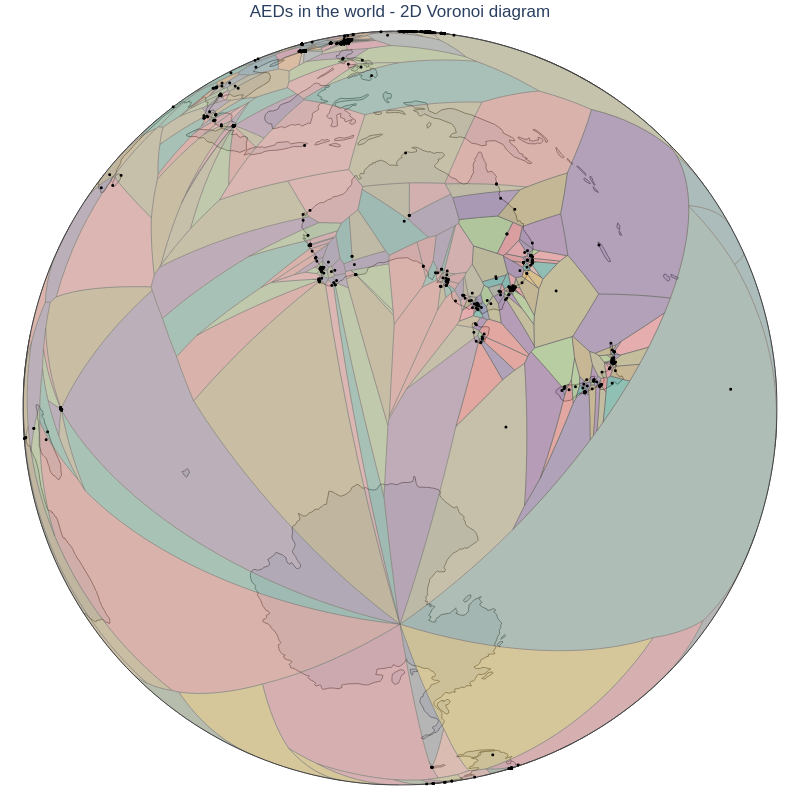

In [20]:
plot_on_globe(
    aed_world_gdf,
    aed_flat_voronoi_regions,
    lon=130,
    lat=-55,
    marker_size=3,
    title="AEDs in the world - 2D Voronoi diagram",
)

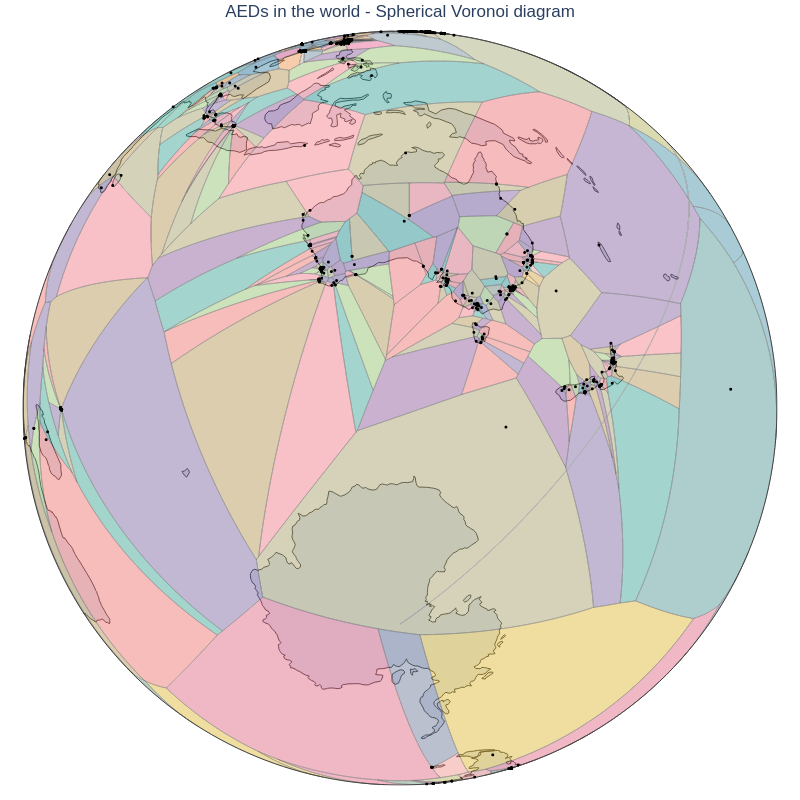

In [21]:
plot_on_globe(
    aed_world_gdf,
    aed_spherical_voronoi_regions,
    lon=130,
    lat=-55,
    marker_size=3,
    title="AEDs in the world - Spherical Voronoi diagram",
)

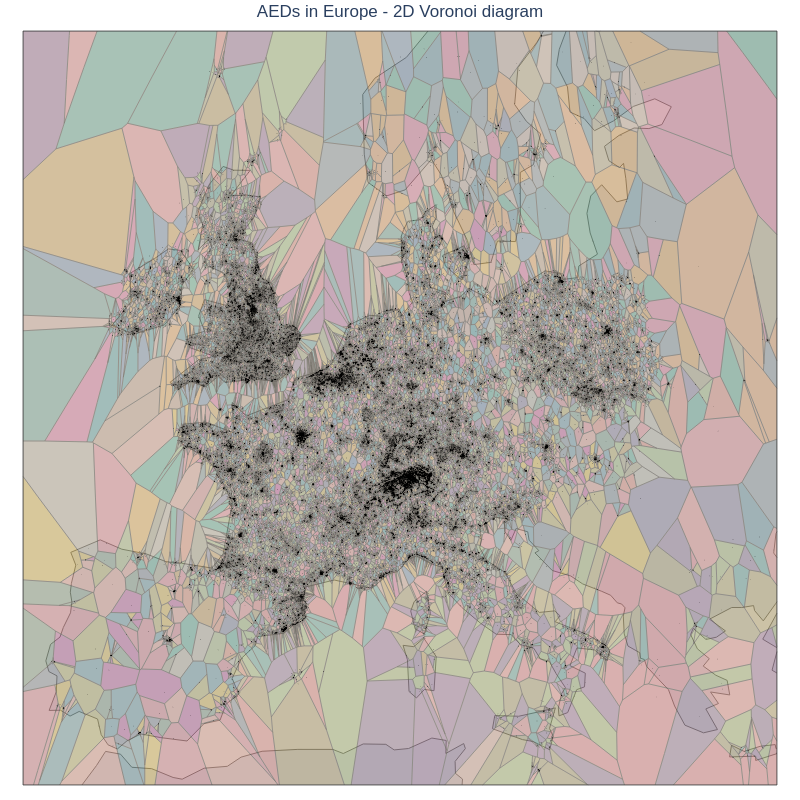

In [22]:
plot_on_globe(
    aed_world_gdf,
    aed_flat_voronoi_regions,
    lon=8,
    lat=50,
    zoom=4,
    marker_size=0.5,
    title="AEDs in Europe - 2D Voronoi diagram",
)

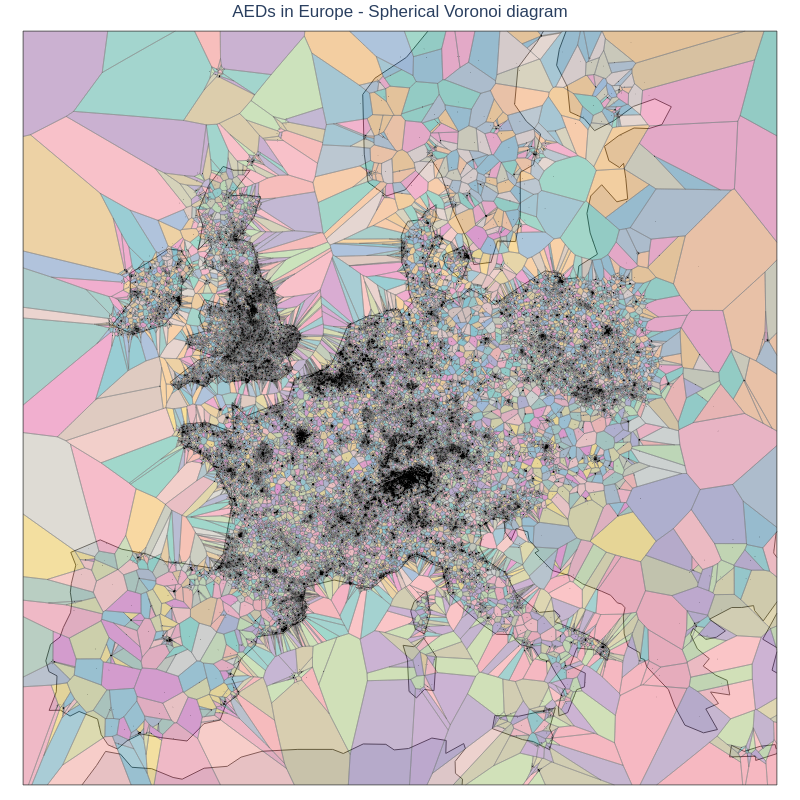

In [23]:
plot_on_globe(
    aed_world_gdf,
    aed_spherical_voronoi_regions,
    lon=8,
    lat=50,
    zoom=4,
    marker_size=0.5,
    title="AEDs in Europe - Spherical Voronoi diagram",
)

In [24]:
print(
    "AEDs on Earth IoU",
    calculate_iou(aed_flat_voronoi_regions, aed_spherical_voronoi_regions),
)

AEDs on Earth IoU 0.511


In [14]:
greater_london_area = geocode_to_region_gdf("Greater London")
aeds_in_london = aed_world_gdf.sjoin(greater_london_area)
aeds_in_london

osm_id  ...                              index_right
1318    8722705574  ...  Greater London, England, United Kingdom
1324    9983760654  ...  Greater London, England, United Kingdom
5450   11369657083  ...  Greater London, England, United Kingdom
7520    7277994642  ...  Greater London, England, United Kingdom
7522   10082336543  ...  Greater London, England, United Kingdom
...            ...  ...                                      ...
78413   9434967293  ...  Greater London, England, United Kingdom
78414   9945715108  ...  Greater London, England, United Kingdom
78415   2620317749  ...  Greater London, England, United Kingdom
78416   4987829021  ...  Greater London, England, United Kingdom
78417  10216571974  ...  Greater London, England, United Kingdom

[211 rows x 3 columns]

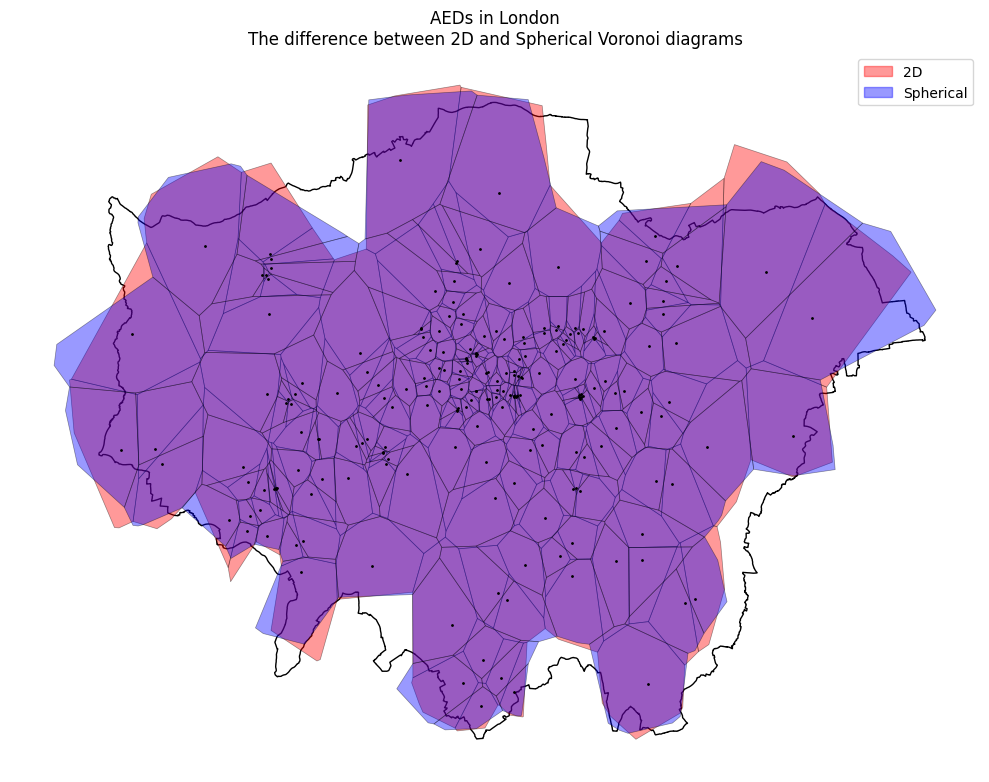

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
greater_london_area.plot(edgecolor="black", linewidth=1, color="white", ax=ax)
aed_flat_voronoi_regions.loc[aeds_in_london.index].plot(
    alpha=0.4, color="red", edgecolor="black", linewidth=0.5, ax=ax
)
aed_spherical_voronoi_regions.loc[aeds_in_london.index].plot(
    alpha=0.4, color="blue", edgecolor="black", linewidth=0.5, ax=ax
)
aeds_in_london.plot(ax=ax, color="black", markersize=1)
ax.set_axis_off()

legend_items = [
    (plt.Rectangle((0, 0), 1, 1, color="red", alpha=0.4), "2D"),
    (plt.Rectangle((0, 0), 1, 1, color="blue", alpha=0.4), "Spherical"),
]
plt.legend(*zip(*legend_items), loc="upper right")
fig.tight_layout()
plt.title("AEDs in London\nThe difference between 2D and Spherical Voronoi diagrams")
plt.show()

In [27]:
print(
    "AEDs in London IoU",
    calculate_iou(
        aed_flat_voronoi_regions.loc[aeds_in_london.index],
        aed_spherical_voronoi_regions.loc[aeds_in_london.index],
    ),
)

AEDs in London IoU 0.675


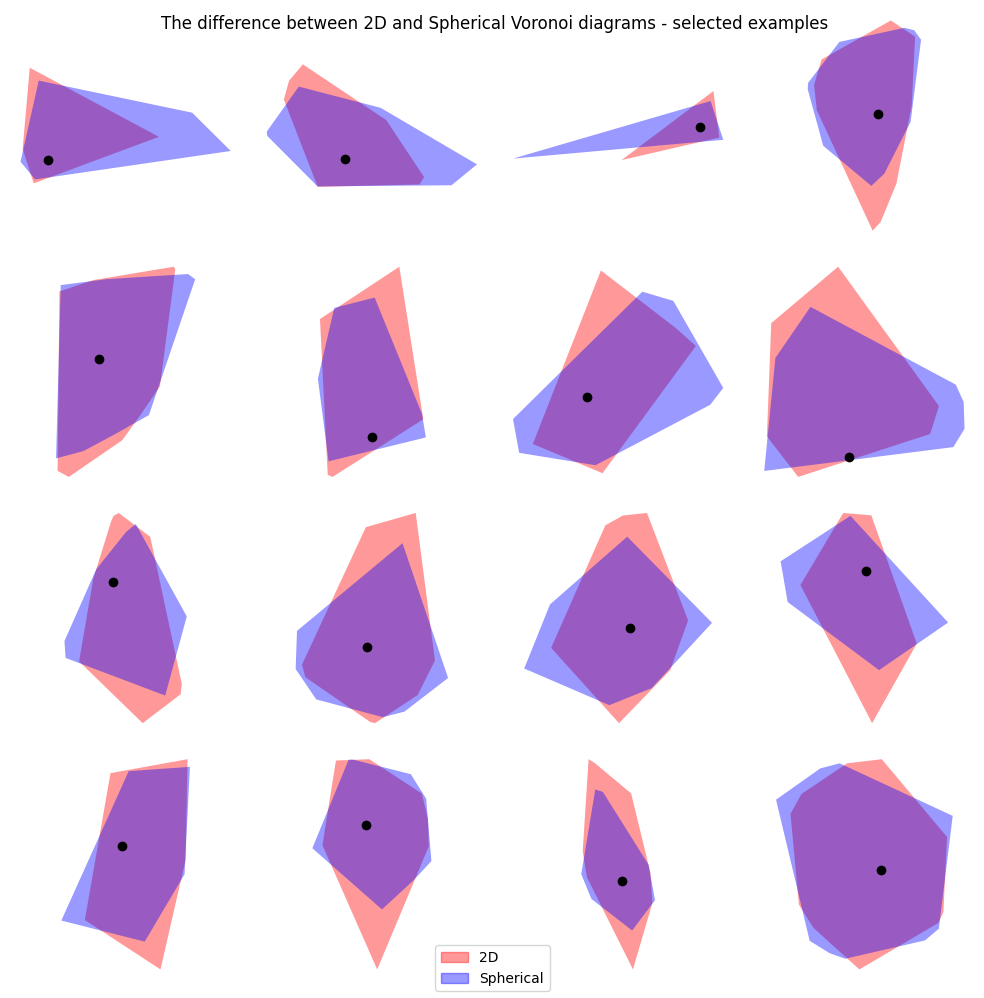

In [28]:
osm_ids = [
    10969028850,
    10969043290,
    10217164514,
    6993967364,
    10172071554,
    9158965590,
    7077380835,
    7001379687,
    11196484106,
    10921165113,
    7299810511,
    2305695266,
    9436428795,
    10864926705,
    6863610536,
    8090696095,
]
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axes = axs.flatten()
for idx, osm_id in enumerate(osm_ids):
    ax = axes[idx]
    aed = aed_world_gdf[aed_world_gdf.osm_id == osm_id]
    index = aed.index[0]
    aed_flat_voronoi_regions.loc[[index]].plot(ax=ax, alpha=0.4, color="red")
    aed_spherical_voronoi_regions.loc[[index]].plot(ax=ax, alpha=0.4, color="blue")
    aed.plot(ax=ax, color="black")
    ax.set_axis_off()

fig.legend(*zip(*legend_items), loc="lower center")
fig.tight_layout()
plt.suptitle(
    "The difference between 2D and Spherical Voronoi diagrams - selected examples"
)
plt.show()

/tmp/ipykernel_6259/2873612322.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


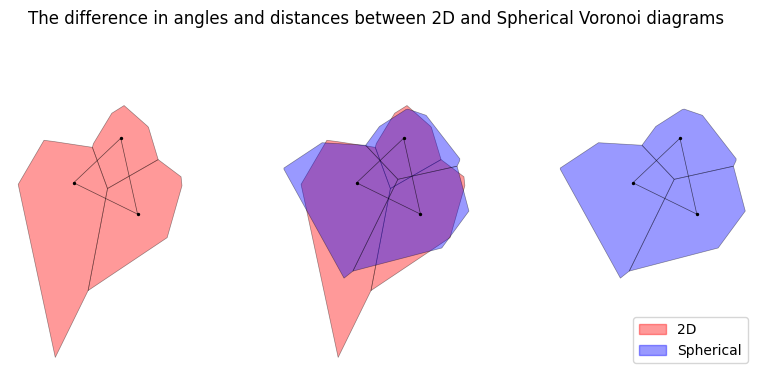

In [66]:
from shapely.geometry import LineString

indexes = [17729, 68321, 48213]

lines = []
for i, idx1 in enumerate(indexes):
    for idx2 in indexes[i + 1 :]:
        lines.append(
            LineString(
                [
                    *aeds_in_london.loc[idx1].geometry.coords,
                    *aeds_in_london.loc[idx2].geometry.coords,
                ]
            )
        )

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(10, 4), sharey=True, constrained_layout=True
)
aed_flat_voronoi_regions.loc[indexes].plot(
    alpha=0.4, color="red", edgecolor="black", linewidth=0.5, ax=ax1
)
aed_spherical_voronoi_regions.loc[indexes].plot(
    alpha=0.4, color="blue", edgecolor="black", linewidth=0.5, ax=ax3
)

aed_flat_voronoi_regions.loc[indexes].plot(
    alpha=0.4, color="red", edgecolor="black", linewidth=0.5, ax=ax2
)
aed_spherical_voronoi_regions.loc[indexes].plot(
    alpha=0.4, color="blue", edgecolor="black", linewidth=0.5, ax=ax2
)

lines_gs = gpd.GeoSeries(lines)

lines_gs.plot(ax=ax1, color="black", alpha=0.6, linewidth=0.5)
lines_gs.plot(ax=ax2, color="black", alpha=0.6, linewidth=0.5)
lines_gs.plot(ax=ax3, color="black", alpha=0.6, linewidth=0.5)

aeds_in_london.loc[indexes].plot(ax=ax1, color="black", markersize=2)
aeds_in_london.loc[indexes].plot(ax=ax2, color="black", markersize=2)
aeds_in_london.loc[indexes].plot(ax=ax3, color="black", markersize=2)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

plt.legend(*zip(*legend_items), loc="lower right")

fig.suptitle(
    "The difference in angles and distances between 2D and Spherical Voronoi diagrams",
)

plt.tight_layout()
plt.show()